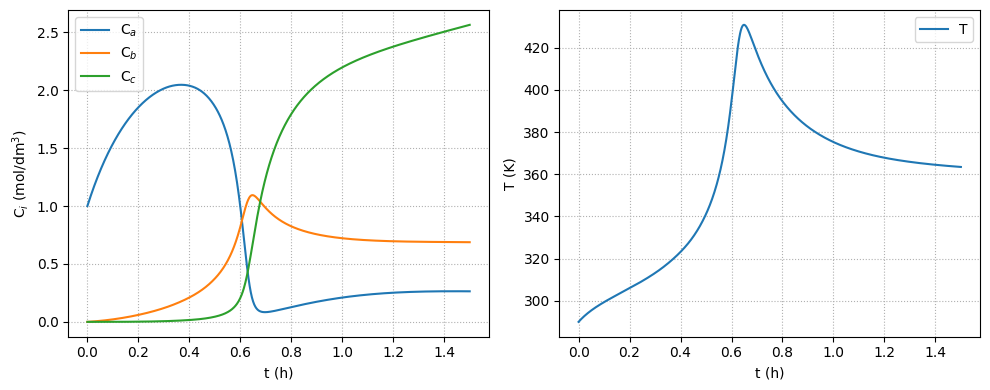

In [2]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# 2A -> B  (R1)
# B  -> 3C (R2)
coeffs = np.array([-2, -1]) # reactant coeffs of A(R1) and B(R2)

#stoichiometry     A,     B,     C
alfa = np.array([ [-2,    1,     0],      # R1
                  [ 0,   -1,     3]])     # R2

scaled_alfa = np.dot(np.diag(1/coeffs), alfa)

# Initially there is a total of 100 dm3 in the reactor, which contains 1.0 mol/dm3 of A and 1.0 mol/dm3 of the catalyst H2S04
CAi = 1 # mol/dm3 at 290K
C_H2SO4 = 1 # mol/dm3 at 290K
v0i = 100 # dm3
N_H2SO4 = C_H2SO4*v0i # mol

CA0 = 4 # mol/dm3 at 305K
v0 = 240 # dm3/h at 305K
FA0 = CA0*v0 # mol/h at 305K
T0 = 305 # K

k1A_ref = 1.25 # h^-1 at 320K
E1A_ref = 9500 # cal/mol at 320K

k2A_ref = 0.08 # h^-1 at 290K
E2A_ref = 7000 # cal/mol at 290K

dHrx1A = -6500 # cal/mol A
dHrx2B = 8000 # cal/mol B

CpA = 30 # cal/mol/K
CpB = 60 # cal/mol/K
CpC = 20 # cal/mol/K
Cp_H2SO4 = 35 # cal/mol/K

UA = 35000 # cal/h/K
Ta = 298 # K

def odes(t, y, *args):
    a, b, c = np.arange(3)
    # assign each ODE (ordinary differential equation) to a vector element
    C = y[:-1]
    T = y[-1]

    # explicit equation inline
    k1A = k1A_ref*np.exp((E1A_ref/1.987)*(1/320-1/T))
    k2B = k2A_ref*np.exp((E2A_ref/1.987)*(1/290-1/T))

    # rate laws
    r1A = -k1A*C[a]
    r2B = -k2B*C[b]
    Ri = np.array([r1A, r2B])
    ri = np.dot(Ri, scaled_alfa)

    V = 100 + v0*t

    # mass balance
    dCa_dt = ri[a] + (CA0-C[0])*v0/V
    dCb_dt = ri[b] - C[b]*v0/V
    dCc_dt = ri[c] - C[c]*v0/V

    # energy balance
    num = (UA*(Ta-T)-FA0*CpA*(T-T0)+((dHrx1A)*r1A+dHrx2B*r2B)*V)
    den = (C[0]*CpA+C[1]*CpB+C[2]*CpC)*V+N_H2SO4*Cp_H2SO4
    dT_dt = num/den

    return np.array([dCa_dt, dCb_dt, dCc_dt, dT_dt])

y0 = np.array([1.0, 0.0, 0.0, 290])

# declare a volume vector (volume window)
time = np.linspace(0, 1.5, 1000)

args = (v0, k1A_ref, E1A_ref, k2A_ref, k2A_ref, UA, Ta, CpA, CpB, CpC, Cp_H2SO4, N_H2SO4, T0, dHrx1A, dHrx2B)

# solution of the ode
sol = solve_ivp(odes, (0, time[-1]), y0, t_eval = time, args = args)

fig, ax = plt.subplots(ncols = 2, figsize = (10,4))

ax[0].plot(sol.t, sol.y[0], label = "C$_a$")
ax[0].plot(sol.t, sol.y[1], label = "C$_b$")
ax[0].plot(sol.t, sol.y[2], label = "C$_c$")
ax[0].set_xlabel("t (h)")
ax[0].set_ylabel("C$_i$ (mol/dm$^3$)")
ax[0].legend()
ax[0].grid(ls = ":")

ax[1].plot(sol.t, sol.y[3], label = "T")
ax[1].set_xlabel("t (h)")
ax[1].set_ylabel("T (K)")
ax[1].legend()
ax[1].grid(ls = ":")

fig.tight_layout()